## ResNet Constructor.
Данный ноутбук содержит контруктор ResNet подобных сетей и пайплайн для работы с ним.
- accuracy на тестовой части датасета Imagenette составляет 0.92
- в pipeline'e реализовано сохранения метрик и модели 

### Oсновые блоки
[Загрузка датасета](#Загрузка_датасета) <br>
[Гиперпараметры обучения](#Гиперпараметры_обучения) <br>
[Просмотр датасета](#Просмотр_датасета) <br>
[Конструктор ResNet-like моделей](#Конструктор_ResNet_подобных_сетей) <br>
[Инициализация модели](#Инициализация_модели) <br>
[Тренировочный цикл](#Тренировочный_цикл) <br>
[Проверка модели](#Проверка_модели) <br>
[Критика](#Критика)

### Загрузка_датасета

In [1]:
conda install -c fastai -c pytorch fastai


# >>>>>>>>>>>>>>>>>>>>>> ERROR REPORT <<<<<<<<<<<<<<<<<<<<<<

    Traceback (most recent call last):
      File "/opt/conda/lib/python3.6/site-packages/urllib3/response.py", line 436, in _error_catcher
        yield
      File "/opt/conda/lib/python3.6/site-packages/urllib3/response.py", line 766, in read_chunked
        chunk = self._handle_chunk(amt)
      File "/opt/conda/lib/python3.6/site-packages/urllib3/response.py", line 710, in _handle_chunk
        value = self._fp._safe_read(amt)
      File "/opt/conda/lib/python3.6/http/client.py", line 622, in _safe_read
        chunk = self.fp.read(min(amt, MAXAMOUNT))
      File "/opt/conda/lib/python3.6/socket.py", line 586, in readinto
        return self._sock.recv_into(b)
      File "/opt/conda/lib/python3.6/ssl.py", line 1012, in recv_into
        return self.read(nbytes, buffer)
      File "/opt/conda/lib/python3.6/ssl.py", line 874, in read
        return self._sslobj.read(len, buffer)
      File "/opt/conda/lib/python3.6/ssl.py"

In [2]:
from fastai.vision import *
path = untar_data(URLs.IMAGENETTE_320, dest ='./imagenette/')
path

PosixPath('imagenette/imagenette2-320')

In [3]:
import torch
import torchvision
from torch import nn
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

### Гиперпараметры_обучения
- batch_size: кол-во изображений в одном батче. Предел зависит от кол-ва памяти на видеокарте
- num_epoch: кол-во эпох обучения.
- learning_rate: скорость обучения.
- optimizer_type: тип оптимизатора, использующегося для обновления весов сети. Может быть 'SGD' или 'Adam'

<b>Архитектура сети:
 - layers - список с количеством стандартных блоков по слоям
 - num_classes - количество классов
 - bottleneck - определяет использование стандартных блоков или 'bottleneck' блоков <br>

(!) Конструктор ожидает на вход изображение с разрешением 224х224х3

Примеры стандартных сетей:<br>
<b>ResNet-18: </b> <br> 
model = ResNet_like(layers=[2,2,2,2], bottleneck=False, num_classes=10)

<b>ResNet-36: </b> <br> 
model = ResNet_like(resnet_layers=[3,4,6,3], bottleneck=False, num_classes=10)

<b>ResNet-50: </b> <br> 
model = ResNet_like(resnet_layers=[3,4,6,3], bottleneck=True, num_classes=10)

<b>ResNet-101: </b> <br> 
model = ResNet_like(resnet_layers=[3,4,23,3], bottleneck=True, num_classes=10)

<b>ResNet-152: </b> <br> 
model = ResNet_like(resnet_layers=[3,8,36,3], bottleneck=True, num_classes=10)
    
<b>Настройка изменения learning rate в течении обучения. </b><br> 
Реализовано две стратегии 'cos' - согласно функции косинуса и 'step' - ступенчатое уменьшение в 10 раз через равные промежутки.
- sheduler_type: задает стратегию. может быть 'cos' или 'step'
- sheduler_cycle: задает кол-во циклов изменения learning rate. Должно быть меньше или равно num_epoch<br> 
Для 'cos' интерпритируется как кол-во циклов убывания learning rate с возвратом к стартовому learning rate в начале нового цикла<br>
Для 'step' интерпритируется как кол-во уменьшений learning rate

Прочее
- dataset_path: путь к папке с датасетом

In [4]:
batch_size = 32
num_epoch = 600
learning_rate = 0.1
optimizer_type = 'SGD'
save_best_model = True

# resnet architecture
resnet_layers = [3,4,6,4]
bottleneck = True
num_classes = 10

# learning_rate_decay
sheduler_type = 'cos'
sheduler_cycle = 4

dataset_path = '../imagenette/imagenette2-320/'
save_model_dir = './models/'
metrics_dir = './metrics/'

Задаем название модели, которое будет фигурировать в названии сохраненных файлов метрики и модели<br>
Название модели является производным от гиперпараметров

In [5]:
if bottleneck == True:
    model_name = f'ResNet{sum(resnet_layers)*3+2}_{optimizer_type}_lr{learning_rate}_b{batch_size}_{sheduler_type}_sc{num_epoch//sheduler_cycle}'
elif bottleneck == False:
    model_name = f'ResNet{sum(resnet_layers)*2+2}_{optimizer_type}_lr{learning_rate}_b{batch_size}_{sheduler_type}_sc{num_epoch//sheduler_cycle}'
model_name

'ResNet53_SGD_lr0.1_b32_cos_sc150'

### Просмотр_датасета

Посмотрим csv, приложенный к датасету

In [6]:
labels_df = pd.read_csv('../imagenette/imagenette2-320/noisy_imagenette.csv')
labels_df.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False
2,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n02979186,n03417042,n03000684,False
3,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n02979186,n03417042,False
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n02979186,n03394916,False


In [7]:
for cols in labels_df.columns:
    print(cols, ' have ', len(labels_df[cols].unique()), 'labels')

path  have  13394 labels
noisy_labels_0  have  10 labels
noisy_labels_1  have  10 labels
noisy_labels_5  have  10 labels
noisy_labels_25  have  10 labels
noisy_labels_50  have  10 labels
is_valid  have  2 labels


Кол-во картинок в тренировочном датасете

In [8]:
labels_df.index[labels_df['is_valid'] == False].max()

9468

Кол-во картинок в тестовом датасете

In [9]:
labels_df.index[labels_df['is_valid'] == True].max()

13393

### Создаем DataLoader попутно предобрабатывая данные

В качетсве аугментаций ипользуется:
- уменьшение картинки до разрешения 260*260
- вырезка случайного квадрата размером 224*244 (сеть ожидает именно эту размерность)
- переворот изображения по горизонтальной оси
- нормализация

In [10]:
from torchvision import transforms, datasets

train_transform = transforms.Compose([
        transforms.Resize((260,260)),
        transforms.RandomSizedCrop(224),
#         transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
#         transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
        transforms.RandomHorizontalFlip(.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
        transforms.Resize((224,224)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

trainset = datasets.ImageFolder(root=dataset_path + '/train/', transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = datasets.ImageFolder(root=dataset_path + '/val/', transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, #batch_size=batch_size,
                                         shuffle=False)

Давайте глянем на примеры картинок и проверим значения классов для них

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


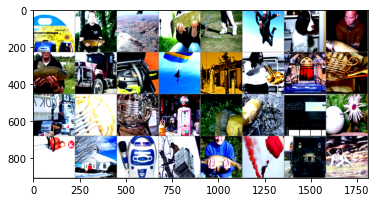

tensor([2, 0, 9, 0, 8, 9, 1, 0, 0, 6, 3, 9, 7, 5, 4, 5, 6, 5, 5, 7, 0, 0, 2, 8,
        3, 4, 2, 3, 0, 9, 6, 1])


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(labels)

## Конструктор_ResNet_подобных_сетей

Выносим в функции сверточные слои для уменьшения количества букв в коде

In [12]:
def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)

def conv3x3(in_channels, out_channels, stride=1,padding=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding)

#### Создаем ResNet блоки через классы.
Класс NormalBlock собирает стандартный ResNet блок.<br>
Класс BottleneckBlock собирает Bottleneck ResNet блок.

Каждый класс ожидает параметры:
 - num_layer - порядковый номер слоя, в котором будет использоваться данных блок. В стандартной ResNet архитектуре ResNet блоки используются со второго слоя.
 - downsample - определяет тип downsampling'а.
     - 0 - downsampling не используется
     - 1 - downsampling используется в блоке, где уменьшается разрешение и увеличивается кол-во каналов
     - -1 - downsampling используется в блоке, где разрешение не уменьшается, но увеличивается кол-во каналов (обычно последний слой)

In [13]:
class NormalBlock(nn.Module):
    def __init__(
        self,
        num_layer,
        downsample = 0,
        
    ):
        super(NormalBlock, self).__init__()
        self.use_downsample = downsample
        if num_layer == 2 and downsample == 1:
            self.in_channels = 16*(2**num_layer)
        elif num_layer > 2 and downsample != 0:
            self.in_channels = 16*(2**(num_layer-1))
        elif downsample == 0: 
            self.in_channels = 16*(2**num_layer)
            
        self.out_channels = 16*(2**num_layer)
        
        if downsample == 1:
            self.downsample = nn.Sequential(
                conv1x1(self.in_channels, self.out_channels, stride=2),
                nn.BatchNorm2d(self.out_channels))
            
            self.conv1 = conv3x3(self.in_channels, self.out_channels, stride=2)
            self.in_channels = self.out_channels
            self.bn1 = nn.BatchNorm2d(self.out_channels)
        elif downsample == -1:
            self.downsample = nn.Sequential(
                conv1x1(self.in_channels, self.out_channels, stride=1),
                nn.BatchNorm2d(self.out_channels)
                )
            self.conv1 = conv3x3(self.in_channels, self.out_channels)
            self.in_channels = self.out_channels
            self.bn1 = nn.BatchNorm2d(self.out_channels)
        elif downsample == 0:
            self.conv1 = conv3x3(self.in_channels, self.out_channels)
            self.in_channels = self.out_channels
            self.bn1 = nn.BatchNorm2d(self.out_channels)
        self.relu = nn.ReLU()
        self.conv2 = conv3x3(self.in_channels, self.out_channels)
        self.bn2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        skip = x
#         print('Block input',x.shape)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
#         print('Block before skip',out.shape)

        if self.use_downsample != 0:
#             print('Before downsample',out.shape, skip.shape)
            skip = self.downsample(x)
#             print('After downsample',out.shape, skip.shape)
        out += skip
        out = self.relu(out)

        return out

class BottleneckBlock(nn.Module):
    def __init__(
        self,
        num_layer,
        downsample = 0
        
    ):
        super(BottleneckBlock, self).__init__()
        
        self.use_downsample = downsample
        if num_layer == 2 and downsample == 1:
            self.in_channels = 16*(2**num_layer)
        elif num_layer > 2 and downsample != 0:
            self.in_channels = 16*(2**(num_layer-1))*4
        elif downsample == 0: 
            self.in_channels = 16*(2**num_layer)*4
            
        self.out_channels = 16*(2**num_layer)
        
        if downsample == 1:
            self.downsample = nn.Sequential(
                conv1x1(self.in_channels, self.out_channels*4, stride=2),
                nn.BatchNorm2d(self.out_channels*4))
            self.conv1 = conv1x1(self.in_channels, self.out_channels,stride=2)
            self.in_channels = self.out_channels
            self.bn1 = nn.BatchNorm2d(self.out_channels)
        elif downsample == -1:
            self.downsample = nn.Sequential(
                conv1x1(self.in_channels, self.out_channels*4, stride=1),
                nn.BatchNorm2d(self.out_channels*4))
            self.conv1 = conv1x1(self.in_channels, self.out_channels)
            self.in_channels = self.out_channels
            self.bn1 = nn.BatchNorm2d(self.out_channels)
        elif downsample == 0:
            self.conv1 = conv1x1(self.in_channels, self.out_channels)
            self.in_channels = self.out_channels
            self.bn1 = nn.BatchNorm2d(self.out_channels)
        self.relu = nn.ReLU()
        self.conv2 = conv3x3(self.in_channels, self.out_channels)
        self.bn2 = nn.BatchNorm2d(self.out_channels)
        self.relu = nn.ReLU()
        self.out_channels = 16*(2**num_layer)*4
        self.conv3 = conv1x1(self.in_channels, self.out_channels)
        self.bn3 = nn.BatchNorm2d(self.out_channels)
        self.in_channels = self.out_channels
        
    def forward(self, x):
        skip = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        if self.use_downsample != 0:
#             print(out.shape, x.shape)
            skip = self.downsample(x)
#             print(out.shape, x.shape)
        out += skip
        out = self.relu(out)
            
        return out

### Класс конструктор ResNet подобных архитектур
Данный класс собирает готовую модель из ResNet-блоков

In [14]:
class ResNet_like(nn.Module):

    def __init__(self, 
                 layers, 
                 num_classes,
                 bottleneck,
                 
                 ):
        
        super(ResNet_like, self).__init__()
        self.first = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
        self.body = nn.Sequential()
        if bottleneck == True:
            for num, layer in enumerate(layers):
                for block in range(layer):
                    if block == 0  and num < len(layers) - 1:
                        downsample = 1
                    elif block == 0 and num == len(layers) - 1:
                        downsample = -1
                    elif block != 0:  
                        downsample = 0
                    self.body.add_module(name='block_%d_%d'%(num+2,block+1), module=BottleneckBlock(num+2, downsample))
        elif bottleneck == False:
            for num, layer in enumerate(layers):
                for block in range(layer):
                    if block == 0  and num < len(layers) - 1:
                        downsample = 1
                    elif block == 0 and num == len(layers) - 1:
                        downsample = -1
                    elif block != 0:  
                        downsample = 0
                    self.body.add_module(name='block_%d_%d'%(num+2,block+1), module=NormalBlock(num+2, downsample))
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        if bottleneck == True:
            self.linear_input = 32*(2**(len(layers)))*4
        else:
            self.linear_input = 32*(2**(len(layers)))
        self.linear = nn.Linear(self.linear_input, num_classes)
        
    def forward(self, x):

        x = self.first(x)
        x = self.body(x)
#         print('Shape input avgpool:', x.shape)
        x = self.avgpool(x)
#         print('Shape input linear:', x.shape)
        x = x.view(x.size(0), -1)
#         print('Shape input linear:', x.shape)
        x = self.linear(x)
#         x = self.final(x)
        
        return x

## Инициализация_модели

Задаем оптимизаторы и создаем планировщик убывания скорости обучения

In [15]:
model = ResNet_like(layers=resnet_layers, bottleneck=bottleneck, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
if optimizer_type == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.0001, momentum=0.9)
elif optimizer_type == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-06, weight_decay=0.0001, amsgrad=False)

if sheduler_type == 'step':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_epoch//sheduler_cycle, gamma=0.1)
elif sheduler_type == 'cos':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, num_epoch//sheduler_cycle, eta_min=0)

Ячейча используется для запуска реализации ResNet в библиотеке PyTorch для сравнения с конструктором.

In [16]:
# from torchvision.models import resnet34
# model = resnet34(num_classes=10)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.learning_rate, momentum=0.9)
# # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epoch, eta_min=0)

Загружаем модель на видеокарту.

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


ResNet_like(
  (first): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (block_2_1): BottleneckBlock(
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05,

Создаем датафрейм для записи метрик обучения. <br>
Датафрейм сохраняется в папку './metrics'

In [18]:
cols_name = ['epoch', 'time', 'current_lr', 'loss', 'accuracy_train', 'accuracy_val']
metrics_frame = pd.DataFrame(columns=cols_name)
metrics_frame_file = (metrics_dir + model_name + '.csv')
metrics_frame_file

'./metrics/ResNet53_SGD_lr0.1_b32_cos_sc150.csv'

## Тренировочный_цикл

    - Основная метрика accuracy (топ1).
    - Метрика сохраняется в словарь и из словаря сохраняется в датасет и выводится на экран.
    - Лучшая мадель согласно валидации сохраняется на диск.

In [ ]:
for epoch in range(num_epoch):  # loop over the dataset multiple times

    model.train()
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
       
        # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         print(data[1])
        inputs, labels = data[0].to(device), data[1].to(device)
#         print(labels)

        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
#         print('Loss: ', loss)
        loss.backward()
        optimizer.step()
    scheduler.step()
    
    #Accuracy train and val
    model.eval()
    correct_train, correct_val = 0, 0
    total_train, total_val = 0, 0
    with torch.no_grad():
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.to(device)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.to(device)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    end_time = time.time()
    metrics = {'epoch': epoch+1,
               'time': end_time - start_time,
               'current_lr': [group['lr'] for group in optimizer.param_groups][0],
               'loss': float(loss),
               'accuracy_train': correct_train/total_train,
               'accuracy_val': correct_val/total_val,
               }

    print("Epoch {}/{}, Time: {:.2f} sec, current_lr: {:.2e}, Loss: {:.3f}, Accuracy_train: {:.3f}, Accuracy_val: {:.3f}".
          format(metrics['epoch'], num_epoch, metrics['time'], metrics['current_lr'], metrics['loss'], metrics['accuracy_train'], metrics['accuracy_val']))
    
    metrics_frame = metrics_frame.append(pd.DataFrame.from_dict(metrics,orient='index').T)
    metrics_frame.to_csv(metrics_frame_file,index=False)
    
    if save_best_model == True:
        if metrics['accuracy_val'] == metrics_frame['accuracy_val'].max():
            torch.save(model, save_model_dir + model_name + '.pt')

Epoch 1/600, Time: 135.36 sec, current_lr: 1.00e-01, Loss: 1.549, Accuracy_train: 0.201, Accuracy_val: 0.192
Epoch 2/600, Time: 135.77 sec, current_lr: 1.00e-01, Loss: 2.098, Accuracy_train: 0.243, Accuracy_val: 0.248
Epoch 3/600, Time: 137.06 sec, current_lr: 9.99e-02, Loss: 2.173, Accuracy_train: 0.262, Accuracy_val: 0.272


### Проверка_модели

Проверяем сохраненную модель на соответствие метрикам в процессе обучения.

In [ ]:
model = torch.load(save_model_dir + model_name + '.pt')
model.eval()

In [ ]:
correct_train, correct_val = 0, 0
total_train, total_val = 0, 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        outputs = outputs.to(device)
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
        
# print('Accuracy final model on validation dataset is: {:.3f})'.format(correct_val/total_val))
print(f'Accuracy final model on the validation dataset is: {(correct_val/total_val):.3f}')

### Критика

Известные проблемы:
- в тренировочном цикле accuracy на тесте и валидации считается по всему датасету, что сильно увеличивает время обучения.
- результат очень сильно зависит от стартового learning_rate. learning_rate для используемых оптимизаторов нужно выбирать в разном диапазоне (0,01-0,1 для SGD и 0,0005-0,03 для Adam), что приводит к некоторой путаницы
- папки './model' и './metrics' должны быть созданы самостоятельно